In [1]:
import pandas as pd
df=pd.read_csv('log.csv',delimiter=',',header='infer')

# Одно действие на куку

In [2]:
#кол-во действий на куку
df_1 = df.groupby('cookie').size().rename('cnt').reset_index().set_index('cookie')
df_2 = df.set_index('cookie').join(df_1).reset_index()

In [3]:
# Действия тех кто совершал действий 1 раз 
df_2[df_2['cnt'] == 1].groupby(['eventtype_group', 'ClientSideAppName']).size().reset_index().\
pivot('eventtype_group', 'ClientSideAppName', 0).sort_values('Android App', ascending = False)

ClientSideAppName,Android App,iPhone App
eventtype_group,,
Request_ItemView,357314.0,5.0
Request_ItemSearch,1598.0,144.0
Request_UserLogin,221.0,18.0
Request,7.0,4.0
Request_UserRegistration,6.0,NaN
Request_ItemAdd,3.0,NaN
Request_UserItemSearch,3.0,19.0
Request_FavoritesItems,1.0,6.0
Request_ItemEdit,1.0,NaN


In [4]:
# Выкидываю тех, кто только просматривал станицу с Андройда
x_bad_1 = df_2[(df_2['cnt'] == 1) & (df_2['eventtype_group'] == 'Request_ItemView') \
     & (df_2['ClientSideAppName'] == 'Android App')]['cookie'].drop_duplicates().values

In [5]:
sx_bad_1 = set(x_bad_1)

# Удаляю тех, кто совершал слишком много действий за час/день

In [6]:
# Добавляю дату время в таблицу
df['date'] = df['event_date'].apply(lambda x: x[:10])
df['hour'] = df['event_date'].apply(lambda x: x[:13])

In [7]:
#Выкидываю плохих с предыдущего шага
df_3 = df[df['cookie'].apply(lambda x: x not in sx_bad_1)]

In [8]:
# Считаю кол-во действий на дату, на время, всего
c_df = df_3.groupby('cookie').size().rename('cnt').reset_index()
c_df1 = c_df.set_index('cookie').join(df_3[['cookie', 'hour']].drop_duplicates().\
                              groupby('cookie').size().rename('cnt_hours').reset_index().set_index('cookie'))
c_df2 = c_df1.join(df_3[['cookie', 'date']].drop_duplicates().groupby('cookie').size().\
                   rename('cnt_dates').reset_index().set_index('cookie')).reset_index()

In [9]:
c_df2['cnt_per_hour'] = c_df2.cnt.values/c_df2.cnt_hours.values
c_df2['cnt_per_date'] = c_df2.cnt.values/c_df2.cnt_dates.values

Кол-во часов на сайте


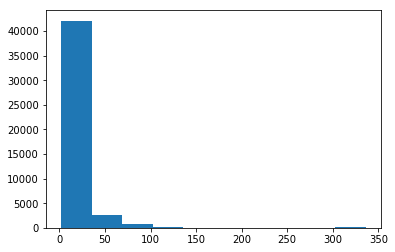

Кол-во дней на сайте


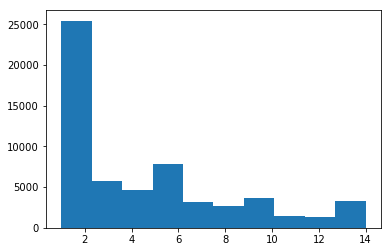

Кол-во посещений в час на сайте


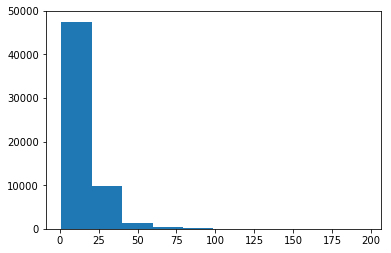

Кол-во посещений в день на сайте


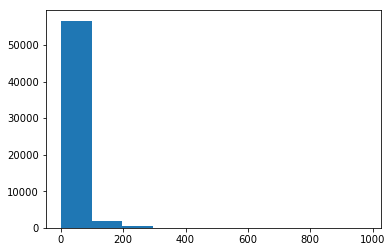

In [10]:
# Графики по величинам
%matplotlib inline
import matplotlib.pyplot as plt

print ('Кол-во часов на сайте'), c_df2['cnt_hours'].mean()
plt.hist(c_df2[c_df2['cnt_hours'] > 1]['cnt_hours'].values)
plt.show()

print ('Кол-во дней на сайте'), c_df2['cnt_dates'].mean()
plt.hist(c_df2['cnt_dates'].values)
plt.show()

print ('Кол-во посещений в час на сайте'), c_df2['cnt_per_hour'].mean()
plt.hist(c_df2[c_df2['cnt_per_hour'] < 200]['cnt_per_hour'].values)
plt.show()

print ('Кол-во посещений в день на сайте'), c_df2['cnt_per_date'].mean()
plt.hist(c_df2[c_df2['cnt_per_date'] < 1000]['cnt_per_date'].values)
plt.show()

In [11]:
#Выкидываю тех у кого кол-во просмотров в день, час и кол-во часов больше среднее*20
x_bad_2 = c_df2[(c_df2['cnt_per_hour'] > c_df2['cnt_per_hour'].mean()*20) |\
      (c_df2['cnt_per_date'] > c_df2['cnt_per_date'].mean()*20) |\
      (c_df2['cnt_hours'] > c_df2['cnt_hours'].mean()*20)]['cookie'].drop_duplicates().values

# соотношение view/search и search/view

In [13]:
#Выкидываю плохих с предыдущего шага
df_4 = df_3[df_3['cookie'].apply(lambda x: x not in sx_bad_2)]

In [14]:
#Ко-во просмотров и поисков
r_df = df_4[(df_4['eventtype_group'] == 'Request_ItemSearch') | (df_4['eventtype_group'] == 'Request_ItemView')].\
    groupby(['cookie', 'eventtype_group']).size().reset_index().pivot('cookie', 'eventtype_group', 0).reset_index()

In [15]:
# Создаю новые переменные соотношение просмотров к поискам и наоборот
r_df['view_search'] = r_df['Request_ItemView']/r_df['Request_ItemSearch']
r_df['search_view'] = r_df['Request_ItemSearch']/r_df['Request_ItemView']

View/Search


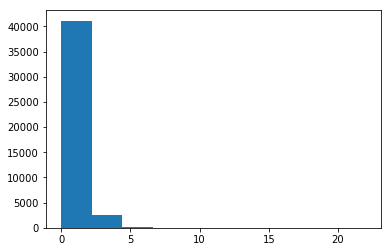

Search/View


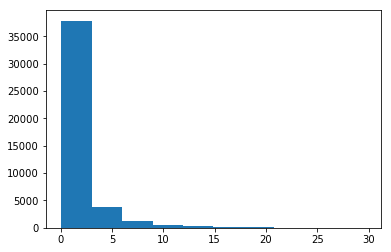

In [16]:
print ('View/Search')
plt.hist(r_df[r_df.view_search < 30]['view_search'].dropna().values)
plt.show()

print ('Search/View')
plt.hist(r_df[r_df.search_view < 30]['search_view'].dropna().values)
plt.show()

In [19]:
# Отбираем в плохие те у кого отношения больше 20
x_bad_3 = r_df[(r_df.view_search > 10) | (r_df.search_view > 20)]['cookie'].drop_duplicates().values
sx_bad_3 = set(x_bad_3)

# Много на один ip

In [20]:
#Выкидываю плохих с предыдущего шага
df_5 = df_4[df_4['cookie'].apply(lambda x: x not in sx_bad_3)]

In [21]:
#сколько куки на 1 ip
i_df = df_5[['ip', 'cookie', 'ClientSideAppName']].drop_duplicates().groupby(['ip', 'ClientSideAppName']).size().\
rename('cnt').reset_index().pivot('ip', 'ClientSideAppName', 'cnt')

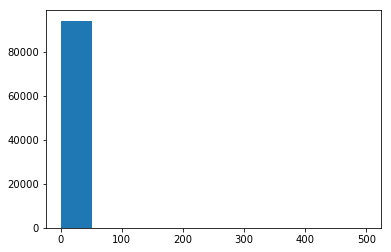

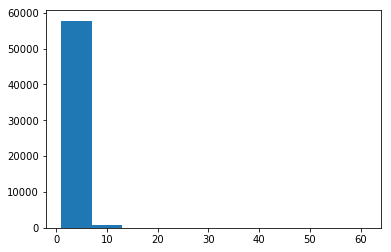

In [22]:
plt.hist(i_df[i_df['Android App'] <500]['Android App'].dropna())
plt.show()

plt.hist(i_df['iPhone App'].dropna())
plt.show()

In [23]:
# только андройд и больше 25 куки
bad_ip = i_df[(i_df['Android App'] > 25) & (i_df['iPhone App'].isnull())].\
    sort_values('Android App', ascending = False).reset_index()['ip'].values

In [24]:
s_bad_ip = set(bad_ip)
x_bad_4 = df_5[df_5.ip.apply(lambda x: x in s_bad_ip)]['cookie'].drop_duplicates().values

# По действиям - получилось выкидывать все просмотры и поиски

In [26]:
#Выкидываю плохих с предыдущего шага
sx_bad_4 = set(x_bad_4)
df_6 = df_5[df_5['cookie'].apply(lambda x: x not in sx_bad_4)]

In [27]:
# какие действия на каждое устройство
e_df = df_6[['cookie', 'ClientSideAppName', 'eventype_name']].drop_duplicates().\
    groupby(['cookie', 'ClientSideAppName'])\
    ['eventype_name'].apply(lambda x: ','.join(set(x))).reset_index().\
    groupby(['ClientSideAppName', 'eventype_name']).size().rename('cnt').reset_index().\
    pivot('eventype_name', 'ClientSideAppName', 'cnt').reset_index().fillna(0.5)

In [28]:
e_df['andr_apple'] = e_df['Android App'].values/e_df['iPhone App'].values

In [29]:
e_df.sort_values('Android App', ascending = False)

ClientSideAppName,eventype_name,Android App,iPhone App,andr_apple
3236,"Items Search,Item View",7856.0,1965.0,3.997964
3360,"Main Page,Items Search,Item View",3478.0,2239.0,1.553372
3212,"Item View,Items Search,Main Page",3472.0,1622.0,2.140567
3222,Items Search,1520.0,363.0,4.187328
3243,"Items Search,Item View,Item View Phone",1456.0,62.0,23.483871
3246,"Items Search,Main Page",978.0,505.0,1.936634
3363,"Main Page,Items Search,Item View,Item View Phone",969.0,248.0,3.907258
2957,Item View,453.0,8.0,56.625000
3215,"Item View,Items Search,Main Page,Item View Phone",359.0,133.0,2.699248
3938,User Login,306.0,58.0,5.275862


In [42]:
# В итоге удаляю все куки с которых были только item_search или item_view 
e_df1 = df_6.groupby(['cookie', 'ClientSideAppName'])['eventype_name'].apply(lambda x: ','.join(set(x))).reset_index()
s_bad_5 = e_df1[((e_df1['eventype_name'] == 'Item View') | (e_df1['eventype_name'] == 'Items Search')) \
                & (e_df1['ClientSideAppName'] == 'Android App')]['cookie'].\
                drop_duplicates().values

In [32]:
sx_bad_5 = set(s_bad_5)
good = set(df_6[df_6['cookie'].apply(lambda x: x not in sx_bad_5)]['cookie'])

In [43]:
#выгружаю для сабмита
res = df[['cookie', 'cookie_id']].drop_duplicates()
res['IsHuman']=df['cookie'].apply(lambda x: 1 if x in good else 0)
res.drop('cookie',axis=1).drop_duplicates().to_csv('submit2_s2.csv',index=False)

In [45]:
subm = res.drop('cookie',axis=1).drop_duplicates()

# Сверху forest, готовлю фичи

In [49]:
df_b=df.set_index('cookie_id').join(subm.set_index('cookie_id')).reset_index()
print (df_b.columns)

Index(['cookie_id', 'log_id', 'event_date', 'eventtype_id', 'eventtype_group',
       'eventype_name', 'is_event_pageview', 'ClientSideAppName', 'cookie',
       'user_id', 'category_id', 'ParentCategoryName', 'CategoryName',
       'location_id', 'useragent_id', 'useragent', 'ip', 'date', 'hour',
       'IsHuman'],
      dtype='object')


In [52]:
#опять дата время
df_b['date']=df_b['event_date'].apply(lambda x:x[:10])
df_b['hour']=df_b['event_date'].apply(lambda x:x[:13])

In [54]:
# считаю уникальное кол-во значений по каждой фиче на 1 куки_id
df_drp=df_b.fillna(-1).groupby('cookie_id')

tmp2=df[['cookie_id']].drop_duplicates().set_index('cookie_id')

for a in [u'eventtype_id',
       u'eventtype_group', u'eventype_name', u'is_event_pageview',
       u'ClientSideAppName', u'cookie', u'user_id', u'category_id',
       u'ParentCategoryName', u'CategoryName', u'location_id', u'useragent_id',
       u'useragent', u'ip','date','hour']:
    print (a)
    tmp2=tmp2.join(df_drp[a].apply(lambda x:len(set(x))).rename('un_'+a).reset_index().set_index('cookie_id'))
    

eventtype_id
eventtype_group
eventype_name
is_event_pageview
ClientSideAppName
cookie
user_id
category_id
ParentCategoryName
CategoryName
location_id
useragent_id
useragent
ip
date
hour


In [64]:
#Число действий
tmp2 = tmp2.join(df.groupby('cookie_id').size().rename('cnt').reset_index().set_index('cookie_id'))

In [65]:
# За день/за час
by_hour=df.groupby(['cookie_id','hour']).size().reset_index().groupby('cookie_id')
by_date=df.groupby(['cookie_id','date']).size().reset_index().groupby('cookie_id')

In [66]:
# Максимальное среднее кол-во действий за час или день
tmp2=tmp2.join(by_hour[0].max().rename('max_by_hour').reset_index().set_index('cookie_id'))
tmp2=tmp2.join(by_hour[0].mean().rename('avg_by_hour').reset_index().set_index('cookie_id'))
tmp2=tmp2.join(by_date[0].max().rename('max_by_date').reset_index().set_index('cookie_id'))
tmp2=tmp2.join(by_date[0].mean().rename('avg_by_date').reset_index().set_index('cookie_id'))

In [67]:
#переименование для dummy
def rename(a,x):
    try:
        return str(a)+'_'+str(x)
    except:
        return x

In [69]:
#категориальные в dummy
import datetime
tmp=[]

for a in [u'eventtype_id',  u'eventtype_group', u'eventype_name', u'is_event_pageview',
       u'ClientSideAppName', u'category_id',
       u'ParentCategoryName', u'CategoryName']:
    print (a, datetime.datetime.now())
    tmp3=pd.get_dummies(df[a])
    tmp3.columns=[rename(a,b) for b in tmp3.columns]
    tmp3=pd.concat([df[['cookie_id']],tmp3], axis=1)
    tmp.append(tmp3.groupby('cookie_id').sum())

eventtype_id 2017-02-18 22:02:01.802604
eventtype_group 2017-02-18 22:02:13.062866
eventype_name 2017-02-18 22:02:19.375961
is_event_pageview 2017-02-18 22:02:27.597692
ClientSideAppName 2017-02-18 22:02:29.180103
category_id 2017-02-18 22:02:31.029113
ParentCategoryName 2017-02-18 22:03:03.836182
CategoryName 2017-02-18 22:03:07.800229


In [77]:
tmp3=tmp[0]

for a in tmp[1:]:
    tmp3=tmp3.join(a)

In [80]:
#Вытаскиваю версию устройства
z=df[['cookie_id','useragent','ClientSideAppName']][df['useragent'].apply(lambda x:'AVITO' in str(x))].drop_duplicates()

z['version']=z.useragent.apply(lambda x:(str(x).split('(')[0].replace('AVITO ','').replace(' ','').replace(',','')))

z['version2']=z.useragent.\
apply(lambda x:(str(x).split('(')[0].replace('AVITO ','').replace(' ','').replace(',','').split('.')[0]))

In [82]:
def try_int(x):
    try:
        return int(x)
    except:
        return None

In [85]:
#из версий dummy
version=pd.get_dummies(z['version'])
version2=pd.get_dummies(z['version'])
v=pd.concat([z[['cookie_id']], version, version2],axis=1).groupby('cookie_id').sum()

In [86]:
#min и max версия для куки
max_v=z.groupby('cookie_id')['version2'].\
apply(lambda x:max([try_int(a) for a in x])).rename('min_verstion').reset_index().set_index('cookie_id')

min_v=z.groupby('cookie_id')['version2'].\
apply(lambda x:min([try_int(a) for a in x])).rename('max_verstion').reset_index().set_index('cookie_id')

tmp3=tmp3.join(v).join(max_v).join(min_v)

In [89]:
final_ds=tmp2.reset_index().set_index('cookie_id').join(tmp3)
final_ds=final_ds.join(df_b[['cookie_id','IsHuman']].drop_duplicates().set_index('cookie_id')).reset_index()
final_ds.to_pickle('finalds')

In [102]:
#разделяю выборку и сохраняю если потом буду использовать
X=final_ds.drop(['cookie_id','IsHuman'],axis=1).values
y=final_ds.IsHuman.values
ids=final_ds.cookie_id.values

import _pickle as pickle
f=open('q2.pk1','wb')
pickle.dump([X,y,ids],f,2)
f.close()

In [104]:
#для forest
# 1. Кросс-валидация
from sklearn.cross_validation import KFold
cv = KFold(len(y),n_folds=5, shuffle=True, random_state=0)

In [96]:
#параметры дерева
import numpy as np
pred=np.zeros(len(y))

from sklearn.ensemble import ExtraTreesClassifier
et=ExtraTreesClassifier(n_estimators=300, n_jobs=-1,min_samples_split=100)

In [110]:
#На 4 частях обучаемся 1 предсказываем
import datetime
# я повторяю эту итерацию 2 раза с разным разбиением
#cv = KFold(len(y),n_folds=6, shuffle=True, random_state=3) 
X[np.isnan(X)]=0
for a,b in cv:
    print (datetime.datetime.now())
    et.fit(X[a],y[a])
    pred[b]=et.predict_proba(X[b])[:,1]

2017-02-19 12:04:56.733485
2017-02-19 12:11:03.742511
2017-02-19 12:16:41.745862
2017-02-19 12:56:29.102560
2017-02-19 13:03:12.884226


In [111]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y, pred)

0.99995768625654879

In [117]:
df=pd.DataFrame(np.concatenate([y.reshape(438657,1), pred.reshape(438657,1)],axis=1),columns=['y','pred'])
df['cookie_id']=ids

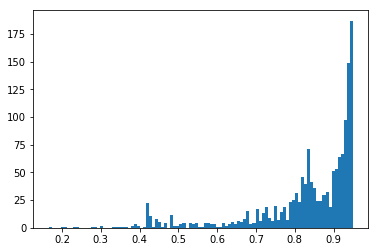

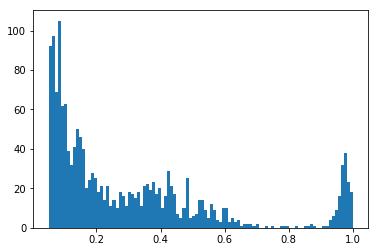

In [130]:
#Распределение верояьностей для 0 и 1
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(df[(df['y']==1) & (df['pred']<0.95)]['pred'].values, bins=100)
plt.show()

plt.hist(df[(df['y']==0) & (df['pred']>0.05)]['pred'].values, bins=100)
plt.show()

In [131]:
# Если вероятность меньше 0,8 а у нас промечен как человек - убираем, если у нас промечен как робот, 
#а вероятность больше 0.2
df['IsHuman']=df[['y','pred']].apply(lambda x: 0 if (x[0]==0 and x[1]<0.2) or (x[0]==1 and x[1]<0.8) else 1,axis=1)
df[['cookie_id','IsHuman']].to_csv('test_v3.csv',index=False)